# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

### Note for grader

My Udacity mentor helped me with some aspects of this project, in particular with the train() function

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
# data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:09<00:00, 6.23KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

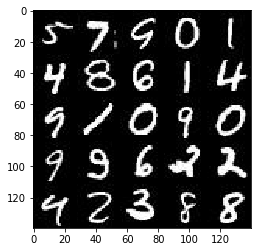

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

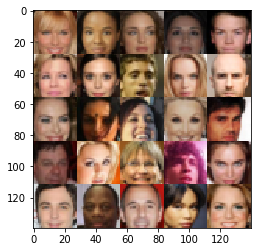

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [132]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name = "input_real")
    input_z = tf.placeholder(tf.float32, (None, z_dim), name="input_z")
    lr = tf.placeholder(tf.float32, name="lr")

    return input_real, input_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [133]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha = 0.2 # As shown in the 'DCGAN' IPython notebook

        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [134]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
#     if is_train == True:
#         reuse = False
#     else:
#         reuse = True
    
    with tf.variable_scope('generator', reuse = not is_train):
        alpha = 0.2
        # First FC layer
        x1 = tf.layers.dense(z, 2*2*512)
        # Reshape to start CNN stack
        x1 = tf.reshape(x1, (-1, 2, 2, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 4x4x512 now

        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides = 2, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides = 2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x128 now

        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides = 2, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [135]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                               labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                               labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                               labels=tf.ones_like(d_model_fake)))
    
    # NB: g_loss is driven entirely by how well the discriminator's logits
    # from fake data aligns to all label 1s. Antagonistically, the d_loss is driven
    # by the ability of the discriminator to maximize alignment of real data
    # to label 1s and fake data to label 0s. The end of the 2-player game is
    # reached as they approach Nash equilibrium, which is when the discriminator
    # simply outputs ~1/2 for both real and fake data.
    
    d_loss = d_loss_real+d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [136]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    training_variables = tf.trainable_variables()
    d_vars = [var for var in training_variables if var.name.startswith('discriminator')]
    g_vars = [var for var in training_variables if var.name.startswith('generator')]
    
    # Begin optimization
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [137]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [140]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    # Define data parameters
    image_width = data_shape[1]
    image_height = data_shape[2]
    image_channels = data_shape[3]
    out_channel_dim = image_channels
    
    # Collect tf input placeholders
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    
    # Calculate losses
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)
    
    # Setup optimization schema
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    # Prepare for training
    saver = tf.train.Saver()
    
    losses = []
    steps = 0
    print_every = 25
    show_every = 100
    n_images = 25
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                batch_images *= 2.0 # Transform range to [-1, 1]; this one line was added with outside help
                
                # Sample noise for generator
                batch_z = np.random.uniform(-1,1, size = (batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict = {input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict = {input_real: batch_images, input_z: batch_z, lr: learning_rate})
                
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                    
                if steps % show_every == 0:
                    
                    show_generator_output(sess, 
                                          n_images, 
                                          input_z,
                                          out_channel_dim, 
                                          data_image_mode)

#         saver.save(sess, './checkpoints/generator.ckpt')
        
#     with open('samples.pkl', 'wb') as f:
#         pkl.dump(samples, f)
        
    return losses      

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.9255 Generator Loss: 8.5122
Epoch 1/2... Discriminator Loss: 0.5123 Generator Loss: 2.5142
Epoch 1/2... Discriminator Loss: 0.4278 Generator Loss: 2.8514
Epoch 1/2... Discriminator Loss: 0.7294 Generator Loss: 2.6310


Epoch 1/2... Discriminator Loss: 0.6493 Generator Loss: 1.9145
Epoch 1/2... Discriminator Loss: 1.3848 Generator Loss: 0.4408
Epoch 1/2... Discriminator Loss: 0.8762 Generator Loss: 1.7063
Epoch 1/2... Discriminator Loss: 1.5985 Generator Loss: 2.1200


Epoch 1/2... Discriminator Loss: 1.7339 Generator Loss: 0.2812
Epoch 1/2... Discriminator Loss: 1.0857 Generator Loss: 0.7654
Epoch 1/2... Discriminator Loss: 1.3333 Generator Loss: 0.3860
Epoch 1/2... Discriminator Loss: 1.3128 Generator Loss: 2.1493


Epoch 1/2... Discriminator Loss: 1.0914 Generator Loss: 1.2866
Epoch 1/2... Discriminator Loss: 1.2584 Generator Loss: 0.4536
Epoch 1/2... Discriminator Loss: 0.8539 Generator Loss: 1.5682
Epoch 1/2... Discriminator Loss: 0.9305 Generator Loss: 1.0871


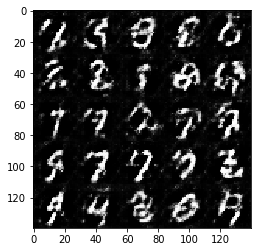

Epoch 1/2... Discriminator Loss: 0.8336 Generator Loss: 0.9408
Epoch 1/2... Discriminator Loss: 1.1079 Generator Loss: 1.7486
Epoch 1/2... Discriminator Loss: 1.1145 Generator Loss: 1.2946
Epoch 1/2... Discriminator Loss: 1.2531 Generator Loss: 1.7831


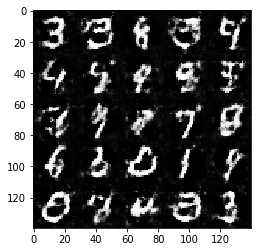

Epoch 1/2... Discriminator Loss: 0.9837 Generator Loss: 1.1644
Epoch 1/2... Discriminator Loss: 1.1216 Generator Loss: 0.9200
Epoch 1/2... Discriminator Loss: 1.3979 Generator Loss: 0.3547
Epoch 1/2... Discriminator Loss: 1.1313 Generator Loss: 1.3794


Epoch 1/2... Discriminator Loss: 1.1588 Generator Loss: 0.7732
Epoch 1/2... Discriminator Loss: 1.0031 Generator Loss: 0.7969
Epoch 1/2... Discriminator Loss: 1.1479 Generator Loss: 0.5461
Epoch 1/2... Discriminator Loss: 1.4830 Generator Loss: 0.3473


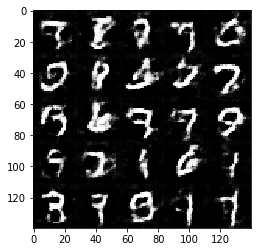

Epoch 1/2... Discriminator Loss: 1.0784 Generator Loss: 0.6404
Epoch 1/2... Discriminator Loss: 1.1384 Generator Loss: 0.5062
Epoch 1/2... Discriminator Loss: 0.9824 Generator Loss: 1.3415
Epoch 1/2... Discriminator Loss: 1.3242 Generator Loss: 0.4030


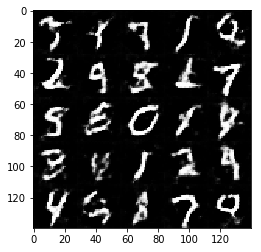

Epoch 1/2... Discriminator Loss: 1.2376 Generator Loss: 0.4631
Epoch 1/2... Discriminator Loss: 1.4822 Generator Loss: 0.3326
Epoch 1/2... Discriminator Loss: 1.1537 Generator Loss: 1.8997
Epoch 1/2... Discriminator Loss: 1.5588 Generator Loss: 0.3148


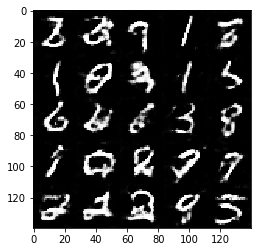

Epoch 1/2... Discriminator Loss: 1.2180 Generator Loss: 0.4596
Epoch 1/2... Discriminator Loss: 0.9208 Generator Loss: 1.4134
Epoch 1/2... Discriminator Loss: 0.8962 Generator Loss: 1.0654
Epoch 1/2... Discriminator Loss: 1.1655 Generator Loss: 0.5119


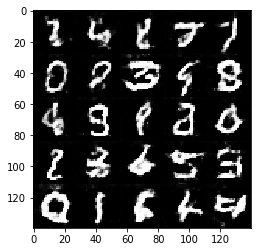

Epoch 1/2... Discriminator Loss: 1.4859 Generator Loss: 0.3049
Epoch 1/2... Discriminator Loss: 0.7984 Generator Loss: 0.9110
Epoch 1/2... Discriminator Loss: 0.7999 Generator Loss: 1.2610
Epoch 1/2... Discriminator Loss: 1.4495 Generator Loss: 2.2205


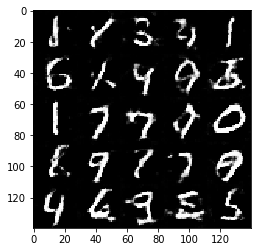

Epoch 1/2... Discriminator Loss: 0.7543 Generator Loss: 1.0246
Epoch 1/2... Discriminator Loss: 0.9438 Generator Loss: 0.7719
Epoch 1/2... Discriminator Loss: 0.9884 Generator Loss: 0.6698
Epoch 1/2... Discriminator Loss: 1.0067 Generator Loss: 0.6607


Epoch 1/2... Discriminator Loss: 2.6125 Generator Loss: 0.1087
Epoch 1/2... Discriminator Loss: 1.1250 Generator Loss: 0.5719
Epoch 1/2... Discriminator Loss: 0.8315 Generator Loss: 1.0150
Epoch 1/2... Discriminator Loss: 0.7991 Generator Loss: 0.8759


Epoch 1/2... Discriminator Loss: 1.1729 Generator Loss: 0.5054
Epoch 1/2... Discriminator Loss: 2.6729 Generator Loss: 4.5431
Epoch 1/2... Discriminator Loss: 0.7731 Generator Loss: 1.2011
Epoch 1/2... Discriminator Loss: 1.1799 Generator Loss: 0.6524


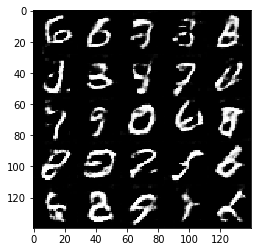

Epoch 1/2... Discriminator Loss: 1.1613 Generator Loss: 0.5179
Epoch 1/2... Discriminator Loss: 0.6884 Generator Loss: 1.2423
Epoch 1/2... Discriminator Loss: 2.3720 Generator Loss: 3.8415
Epoch 1/2... Discriminator Loss: 2.0284 Generator Loss: 0.1940


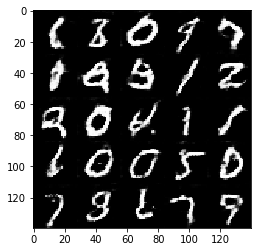

Epoch 1/2... Discriminator Loss: 1.0434 Generator Loss: 1.5516
Epoch 1/2... Discriminator Loss: 0.9552 Generator Loss: 1.0863
Epoch 1/2... Discriminator Loss: 0.7799 Generator Loss: 0.9026
Epoch 1/2... Discriminator Loss: 0.8656 Generator Loss: 0.7641


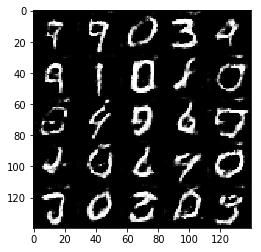

Epoch 1/2... Discriminator Loss: 2.0244 Generator Loss: 0.2154
Epoch 1/2... Discriminator Loss: 1.3585 Generator Loss: 0.4259
Epoch 1/2... Discriminator Loss: 0.9073 Generator Loss: 0.7298
Epoch 1/2... Discriminator Loss: 1.0254 Generator Loss: 1.8859


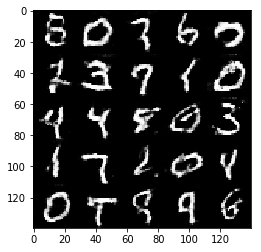

Epoch 1/2... Discriminator Loss: 0.5486 Generator Loss: 1.6368
Epoch 1/2... Discriminator Loss: 1.2547 Generator Loss: 0.5698
Epoch 1/2... Discriminator Loss: 1.6975 Generator Loss: 0.3011
Epoch 1/2... Discriminator Loss: 0.5774 Generator Loss: 1.0428


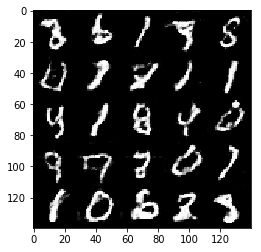

Epoch 1/2... Discriminator Loss: 0.6688 Generator Loss: 1.1212
Epoch 1/2... Discriminator Loss: 0.7008 Generator Loss: 0.9077
Epoch 1/2... Discriminator Loss: 0.6309 Generator Loss: 1.2427
Epoch 2/2... Discriminator Loss: 0.5307 Generator Loss: 1.3246


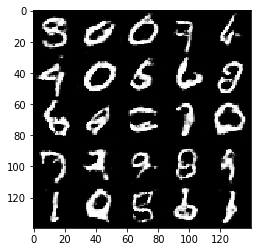

Epoch 2/2... Discriminator Loss: 1.3376 Generator Loss: 0.4259
Epoch 2/2... Discriminator Loss: 0.9622 Generator Loss: 0.7022
Epoch 2/2... Discriminator Loss: 0.7936 Generator Loss: 0.8157
Epoch 2/2... Discriminator Loss: 1.4871 Generator Loss: 3.9814


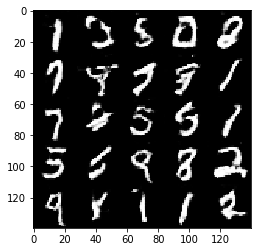

Epoch 2/2... Discriminator Loss: 0.3793 Generator Loss: 1.6122
Epoch 2/2... Discriminator Loss: 0.9259 Generator Loss: 0.6904
Epoch 2/2... Discriminator Loss: 0.5765 Generator Loss: 1.1122
Epoch 2/2... Discriminator Loss: 0.8243 Generator Loss: 0.9098


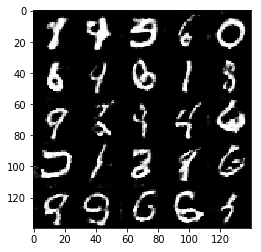

Epoch 2/2... Discriminator Loss: 0.6269 Generator Loss: 1.0932
Epoch 2/2... Discriminator Loss: 0.6262 Generator Loss: 1.5465
Epoch 2/2... Discriminator Loss: 0.5792 Generator Loss: 1.0635
Epoch 2/2... Discriminator Loss: 1.4598 Generator Loss: 0.3392


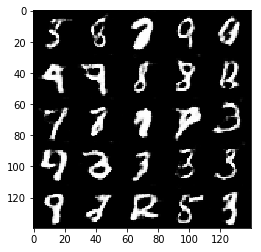

Epoch 2/2... Discriminator Loss: 0.9703 Generator Loss: 0.6119
Epoch 2/2... Discriminator Loss: 0.5217 Generator Loss: 1.2603
Epoch 2/2... Discriminator Loss: 0.9718 Generator Loss: 0.6644
Epoch 2/2... Discriminator Loss: 1.4729 Generator Loss: 0.5169


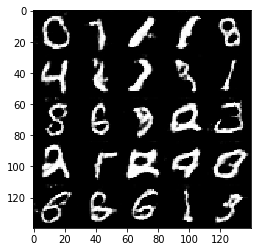

Epoch 2/2... Discriminator Loss: 0.7730 Generator Loss: 0.9188
Epoch 2/2... Discriminator Loss: 0.5185 Generator Loss: 1.4918
Epoch 2/2... Discriminator Loss: 1.4309 Generator Loss: 0.3818
Epoch 2/2... Discriminator Loss: 0.6349 Generator Loss: 2.3760


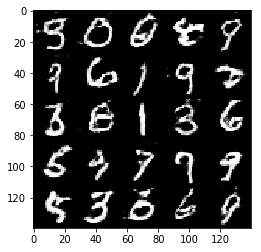

Epoch 2/2... Discriminator Loss: 1.0769 Generator Loss: 0.5556
Epoch 2/2... Discriminator Loss: 0.5490 Generator Loss: 1.2510
Epoch 2/2... Discriminator Loss: 1.0897 Generator Loss: 0.5258
Epoch 2/2... Discriminator Loss: 1.7052 Generator Loss: 0.3180


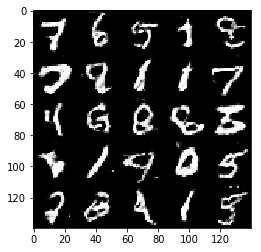

Epoch 2/2... Discriminator Loss: 0.4056 Generator Loss: 2.5231
Epoch 2/2... Discriminator Loss: 0.7821 Generator Loss: 0.8872
Epoch 2/2... Discriminator Loss: 0.4802 Generator Loss: 1.3394
Epoch 2/2... Discriminator Loss: 0.3658 Generator Loss: 1.7197


Epoch 2/2... Discriminator Loss: 0.5528 Generator Loss: 2.5839
Epoch 2/2... Discriminator Loss: 0.9581 Generator Loss: 0.6643
Epoch 2/2... Discriminator Loss: 0.4759 Generator Loss: 1.2844
Epoch 2/2... Discriminator Loss: 0.4685 Generator Loss: 1.7701


Epoch 2/2... Discriminator Loss: 1.0170 Generator Loss: 0.5875
Epoch 2/2... Discriminator Loss: 1.5997 Generator Loss: 0.3928
Epoch 2/2... Discriminator Loss: 1.1303 Generator Loss: 0.4870
Epoch 2/2... Discriminator Loss: 1.3687 Generator Loss: 0.4626


Epoch 2/2... Discriminator Loss: 1.1189 Generator Loss: 0.5453
Epoch 2/2... Discriminator Loss: 0.5305 Generator Loss: 1.2502
Epoch 2/2... Discriminator Loss: 1.0584 Generator Loss: 0.6732
Epoch 2/2... Discriminator Loss: 1.4510 Generator Loss: 0.5019


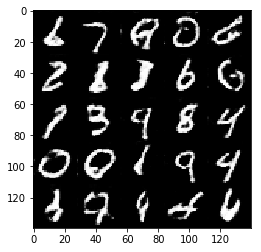

Epoch 2/2... Discriminator Loss: 0.4929 Generator Loss: 1.2157
Epoch 2/2... Discriminator Loss: 0.3642 Generator Loss: 1.6245
Epoch 2/2... Discriminator Loss: 0.7417 Generator Loss: 1.1161
Epoch 2/2... Discriminator Loss: 0.2329 Generator Loss: 1.9224


Epoch 2/2... Discriminator Loss: 0.7158 Generator Loss: 0.8654
Epoch 2/2... Discriminator Loss: 0.6904 Generator Loss: 0.9930
Epoch 2/2... Discriminator Loss: 0.9260 Generator Loss: 0.6493
Epoch 2/2... Discriminator Loss: 1.1124 Generator Loss: 0.6178


Epoch 2/2... Discriminator Loss: 0.6773 Generator Loss: 1.1455
Epoch 2/2... Discriminator Loss: 1.3713 Generator Loss: 4.4168
Epoch 2/2... Discriminator Loss: 0.9813 Generator Loss: 0.6200
Epoch 2/2... Discriminator Loss: 1.8209 Generator Loss: 0.2830


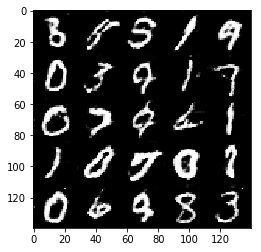

Epoch 2/2... Discriminator Loss: 0.5809 Generator Loss: 1.0816
Epoch 2/2... Discriminator Loss: 0.3834 Generator Loss: 1.3530
Epoch 2/2... Discriminator Loss: 0.5903 Generator Loss: 1.1012
Epoch 2/2... Discriminator Loss: 1.9663 Generator Loss: 0.2613


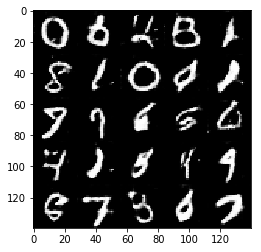

Epoch 2/2... Discriminator Loss: 0.4084 Generator Loss: 1.9420
Epoch 2/2... Discriminator Loss: 0.7031 Generator Loss: 0.9580
Epoch 2/2... Discriminator Loss: 0.6057 Generator Loss: 1.1536
Epoch 2/2... Discriminator Loss: 1.0604 Generator Loss: 3.5529


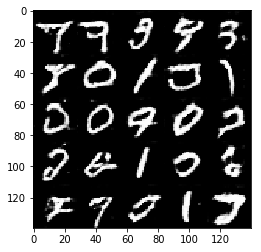

Epoch 2/2... Discriminator Loss: 0.6411 Generator Loss: 1.1323
Epoch 2/2... Discriminator Loss: 0.4159 Generator Loss: 1.8950
Epoch 2/2... Discriminator Loss: 0.9933 Generator Loss: 0.6156
Epoch 2/2... Discriminator Loss: 0.7066 Generator Loss: 0.9698


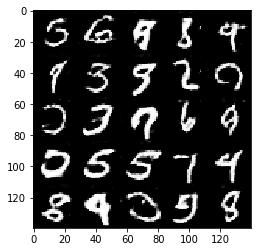

Epoch 2/2... Discriminator Loss: 1.9153 Generator Loss: 0.2239
Epoch 2/2... Discriminator Loss: 1.0746 Generator Loss: 0.7231
Epoch 2/2... Discriminator Loss: 0.3430 Generator Loss: 1.6474
Epoch 2/2... Discriminator Loss: 1.1145 Generator Loss: 0.7509


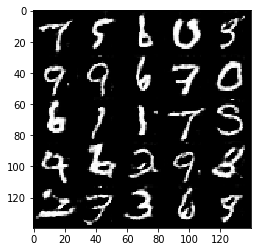

Epoch 2/2... Discriminator Loss: 0.2834 Generator Loss: 1.9074
Epoch 2/2... Discriminator Loss: 1.6201 Generator Loss: 0.4061
Epoch 2/2... Discriminator Loss: 0.8758 Generator Loss: 0.8338
Epoch 2/2... Discriminator Loss: 0.5655 Generator Loss: 1.1092


Epoch 2/2... Discriminator Loss: 0.4462 Generator Loss: 1.2975
Epoch 2/2... Discriminator Loss: 0.4964 Generator Loss: 1.3310


In [141]:
batch_size = 32
z_dim = 100
learning_rate = 0.0003
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 3.6233 Generator Loss: 0.0410
Epoch 1/1... Discriminator Loss: 0.6288 Generator Loss: 1.1394
Epoch 1/1... Discriminator Loss: 2.6629 Generator Loss: 0.1195
Epoch 1/1... Discriminator Loss: 1.4369 Generator Loss: 2.7735


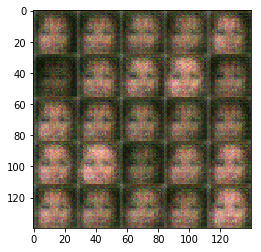

Epoch 1/1... Discriminator Loss: 1.3113 Generator Loss: 2.2254
Epoch 1/1... Discriminator Loss: 1.3487 Generator Loss: 0.6141
Epoch 1/1... Discriminator Loss: 1.4730 Generator Loss: 0.9178
Epoch 1/1... Discriminator Loss: 1.3517 Generator Loss: 0.5369


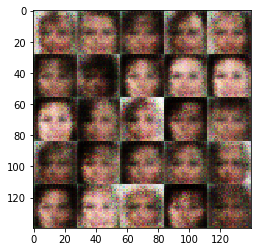

Epoch 1/1... Discriminator Loss: 1.2910 Generator Loss: 1.2920
Epoch 1/1... Discriminator Loss: 1.5041 Generator Loss: 0.3822
Epoch 1/1... Discriminator Loss: 1.1379 Generator Loss: 1.2809
Epoch 1/1... Discriminator Loss: 1.1461 Generator Loss: 1.3636


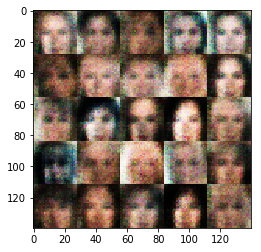

Epoch 1/1... Discriminator Loss: 1.0586 Generator Loss: 0.9075
Epoch 1/1... Discriminator Loss: 1.1669 Generator Loss: 0.6201
Epoch 1/1... Discriminator Loss: 1.2909 Generator Loss: 0.5744
Epoch 1/1... Discriminator Loss: 1.4069 Generator Loss: 1.4129


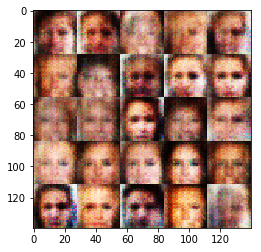

Epoch 1/1... Discriminator Loss: 1.4672 Generator Loss: 0.4012
Epoch 1/1... Discriminator Loss: 1.2505 Generator Loss: 0.5963
Epoch 1/1... Discriminator Loss: 1.3260 Generator Loss: 1.0281
Epoch 1/1... Discriminator Loss: 1.2416 Generator Loss: 0.5910


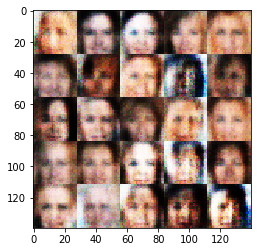

Epoch 1/1... Discriminator Loss: 1.2403 Generator Loss: 0.7099
Epoch 1/1... Discriminator Loss: 1.3412 Generator Loss: 0.8469
Epoch 1/1... Discriminator Loss: 1.3506 Generator Loss: 0.5133
Epoch 1/1... Discriminator Loss: 1.4443 Generator Loss: 0.3869


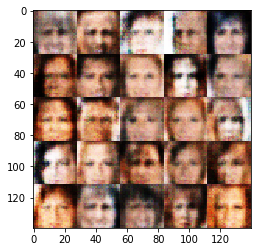

Epoch 1/1... Discriminator Loss: 1.4077 Generator Loss: 1.4601
Epoch 1/1... Discriminator Loss: 1.4244 Generator Loss: 1.5809
Epoch 1/1... Discriminator Loss: 1.5047 Generator Loss: 0.3548
Epoch 1/1... Discriminator Loss: 1.3730 Generator Loss: 1.5886


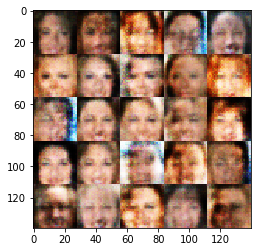

Epoch 1/1... Discriminator Loss: 1.0961 Generator Loss: 0.7381
Epoch 1/1... Discriminator Loss: 1.1789 Generator Loss: 0.6961
Epoch 1/1... Discriminator Loss: 1.2489 Generator Loss: 1.1234
Epoch 1/1... Discriminator Loss: 1.2526 Generator Loss: 0.9418


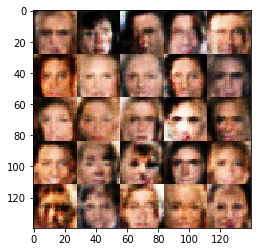

Epoch 1/1... Discriminator Loss: 1.1388 Generator Loss: 0.7745
Epoch 1/1... Discriminator Loss: 1.1696 Generator Loss: 1.4952
Epoch 1/1... Discriminator Loss: 1.1585 Generator Loss: 0.6871
Epoch 1/1... Discriminator Loss: 1.1147 Generator Loss: 1.4445


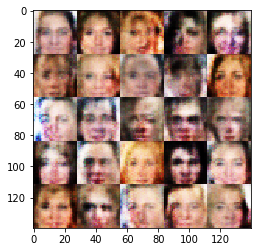

Epoch 1/1... Discriminator Loss: 1.6319 Generator Loss: 0.3206
Epoch 1/1... Discriminator Loss: 1.3187 Generator Loss: 1.1114
Epoch 1/1... Discriminator Loss: 1.3384 Generator Loss: 0.5916
Epoch 1/1... Discriminator Loss: 1.1888 Generator Loss: 0.9654


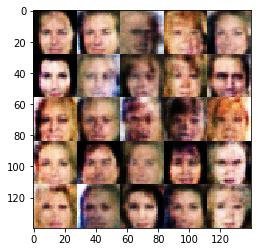

Epoch 1/1... Discriminator Loss: 1.5083 Generator Loss: 0.3785
Epoch 1/1... Discriminator Loss: 1.3110 Generator Loss: 1.1440
Epoch 1/1... Discriminator Loss: 1.5495 Generator Loss: 1.2403
Epoch 1/1... Discriminator Loss: 1.1668 Generator Loss: 0.6441


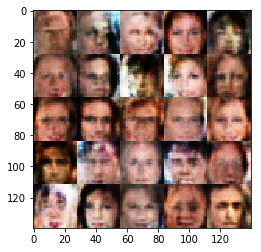

Epoch 1/1... Discriminator Loss: 1.1575 Generator Loss: 1.3259
Epoch 1/1... Discriminator Loss: 0.9500 Generator Loss: 1.4587
Epoch 1/1... Discriminator Loss: 1.6292 Generator Loss: 0.3081
Epoch 1/1... Discriminator Loss: 1.8293 Generator Loss: 0.2199


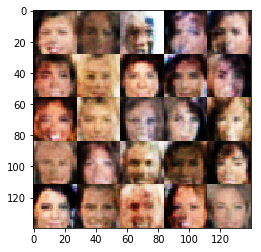

Epoch 1/1... Discriminator Loss: 1.0646 Generator Loss: 1.1724
Epoch 1/1... Discriminator Loss: 1.2190 Generator Loss: 0.5863
Epoch 1/1... Discriminator Loss: 1.5554 Generator Loss: 0.3257
Epoch 1/1... Discriminator Loss: 1.3635 Generator Loss: 0.5332


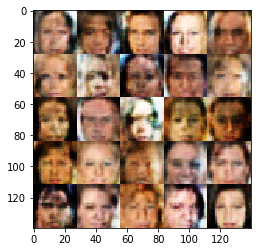

Epoch 1/1... Discriminator Loss: 1.2904 Generator Loss: 0.6205
Epoch 1/1... Discriminator Loss: 1.3260 Generator Loss: 0.4873
Epoch 1/1... Discriminator Loss: 1.4393 Generator Loss: 1.3106
Epoch 1/1... Discriminator Loss: 1.7327 Generator Loss: 0.2516


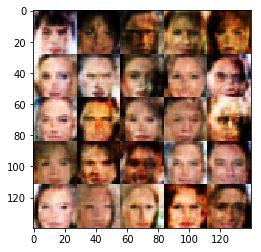

Epoch 1/1... Discriminator Loss: 1.1274 Generator Loss: 0.6913
Epoch 1/1... Discriminator Loss: 1.4083 Generator Loss: 0.3751
Epoch 1/1... Discriminator Loss: 1.1873 Generator Loss: 1.8563
Epoch 1/1... Discriminator Loss: 1.5497 Generator Loss: 0.3071


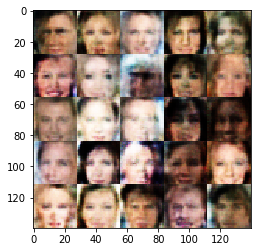

Epoch 1/1... Discriminator Loss: 0.8440 Generator Loss: 1.4018
Epoch 1/1... Discriminator Loss: 0.9046 Generator Loss: 0.8824
Epoch 1/1... Discriminator Loss: 1.6349 Generator Loss: 0.8729
Epoch 1/1... Discriminator Loss: 1.1756 Generator Loss: 0.7427


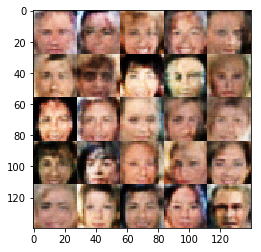

Epoch 1/1... Discriminator Loss: 0.9793 Generator Loss: 0.9253
Epoch 1/1... Discriminator Loss: 1.3519 Generator Loss: 0.9649
Epoch 1/1... Discriminator Loss: 1.3498 Generator Loss: 0.6537
Epoch 1/1... Discriminator Loss: 1.4253 Generator Loss: 0.3863


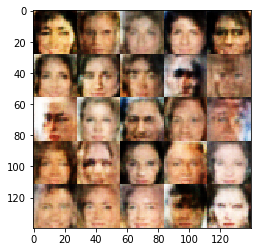

Epoch 1/1... Discriminator Loss: 1.3786 Generator Loss: 1.6687
Epoch 1/1... Discriminator Loss: 1.1101 Generator Loss: 0.6362
Epoch 1/1... Discriminator Loss: 1.2210 Generator Loss: 0.6593
Epoch 1/1... Discriminator Loss: 1.4409 Generator Loss: 1.2147


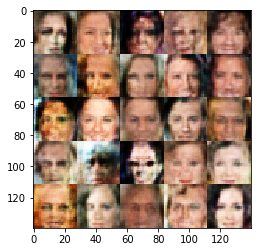

Epoch 1/1... Discriminator Loss: 1.7067 Generator Loss: 0.2624
Epoch 1/1... Discriminator Loss: 1.8564 Generator Loss: 1.6671
Epoch 1/1... Discriminator Loss: 1.1845 Generator Loss: 1.0392
Epoch 1/1... Discriminator Loss: 1.1542 Generator Loss: 0.8420


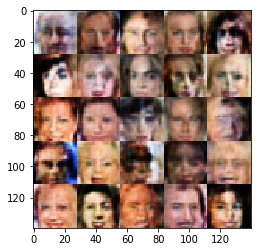

Epoch 1/1... Discriminator Loss: 1.5946 Generator Loss: 0.2796
Epoch 1/1... Discriminator Loss: 1.4109 Generator Loss: 0.4417
Epoch 1/1... Discriminator Loss: 1.0700 Generator Loss: 0.7046
Epoch 1/1... Discriminator Loss: 1.6045 Generator Loss: 0.2882


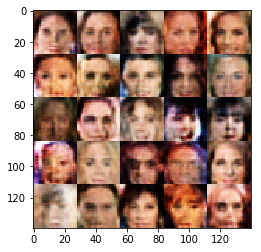

Epoch 1/1... Discriminator Loss: 1.1708 Generator Loss: 0.5418
Epoch 1/1... Discriminator Loss: 0.9219 Generator Loss: 1.8936
Epoch 1/1... Discriminator Loss: 2.1559 Generator Loss: 2.2415
Epoch 1/1... Discriminator Loss: 1.4407 Generator Loss: 0.4552


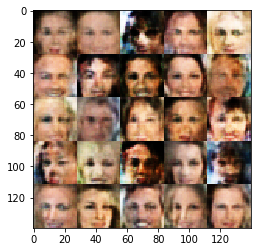

Epoch 1/1... Discriminator Loss: 1.1717 Generator Loss: 0.6116
Epoch 1/1... Discriminator Loss: 1.4584 Generator Loss: 0.3457
Epoch 1/1... Discriminator Loss: 1.0766 Generator Loss: 0.5427
Epoch 1/1... Discriminator Loss: 1.3684 Generator Loss: 1.2689


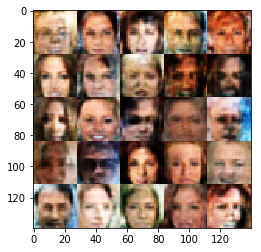

Epoch 1/1... Discriminator Loss: 1.0309 Generator Loss: 1.7659
Epoch 1/1... Discriminator Loss: 0.6238 Generator Loss: 1.8337
Epoch 1/1... Discriminator Loss: 1.2393 Generator Loss: 1.1003
Epoch 1/1... Discriminator Loss: 1.6665 Generator Loss: 1.4505


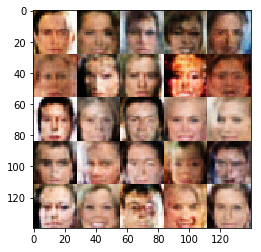

Epoch 1/1... Discriminator Loss: 1.4495 Generator Loss: 0.3562
Epoch 1/1... Discriminator Loss: 1.1500 Generator Loss: 0.5882
Epoch 1/1... Discriminator Loss: 1.3948 Generator Loss: 0.4098
Epoch 1/1... Discriminator Loss: 1.5907 Generator Loss: 0.3070


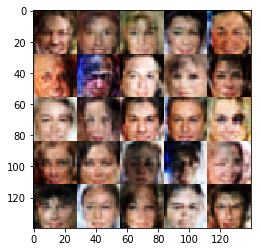

Epoch 1/1... Discriminator Loss: 1.5697 Generator Loss: 1.3485
Epoch 1/1... Discriminator Loss: 0.8561 Generator Loss: 1.2900
Epoch 1/1... Discriminator Loss: 1.5237 Generator Loss: 0.3201
Epoch 1/1... Discriminator Loss: 1.3786 Generator Loss: 0.5113


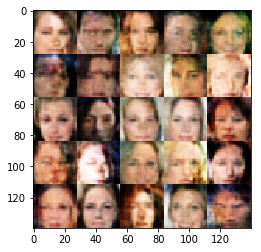

Epoch 1/1... Discriminator Loss: 1.5938 Generator Loss: 0.2753
Epoch 1/1... Discriminator Loss: 1.2354 Generator Loss: 0.4828
Epoch 1/1... Discriminator Loss: 1.2648 Generator Loss: 0.4436
Epoch 1/1... Discriminator Loss: 0.9815 Generator Loss: 0.7117


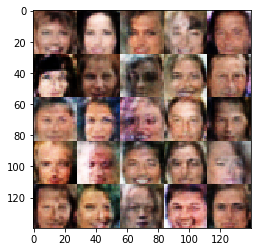

Epoch 1/1... Discriminator Loss: 1.3905 Generator Loss: 0.3649
Epoch 1/1... Discriminator Loss: 1.1159 Generator Loss: 0.7022
Epoch 1/1... Discriminator Loss: 0.9832 Generator Loss: 1.0643
Epoch 1/1... Discriminator Loss: 0.7051 Generator Loss: 1.3239


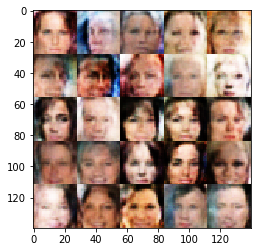

Epoch 1/1... Discriminator Loss: 1.0236 Generator Loss: 0.8601
Epoch 1/1... Discriminator Loss: 0.8483 Generator Loss: 2.2410
Epoch 1/1... Discriminator Loss: 1.4540 Generator Loss: 0.3378
Epoch 1/1... Discriminator Loss: 0.8629 Generator Loss: 0.8187


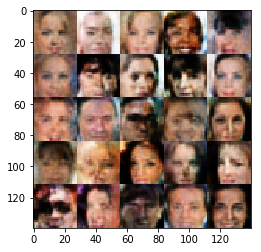

Epoch 1/1... Discriminator Loss: 0.6228 Generator Loss: 1.5982
Epoch 1/1... Discriminator Loss: 1.1018 Generator Loss: 0.5066
Epoch 1/1... Discriminator Loss: 0.9860 Generator Loss: 0.6860
Epoch 1/1... Discriminator Loss: 0.9448 Generator Loss: 0.7129


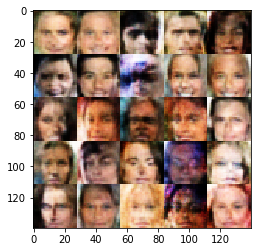

Epoch 1/1... Discriminator Loss: 0.5857 Generator Loss: 1.8756
Epoch 1/1... Discriminator Loss: 1.0579 Generator Loss: 0.5637
Epoch 1/1... Discriminator Loss: 0.7579 Generator Loss: 2.0318
Epoch 1/1... Discriminator Loss: 0.4996 Generator Loss: 1.5955


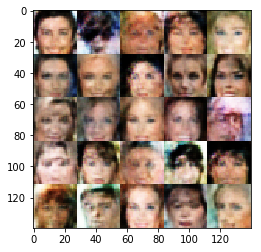

Epoch 1/1... Discriminator Loss: 0.8535 Generator Loss: 0.8680
Epoch 1/1... Discriminator Loss: 0.8685 Generator Loss: 1.5254
Epoch 1/1... Discriminator Loss: 0.7698 Generator Loss: 2.0113
Epoch 1/1... Discriminator Loss: 1.2757 Generator Loss: 0.4068


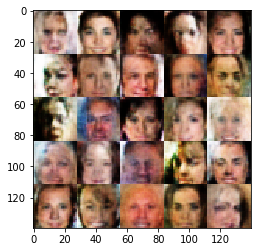

Epoch 1/1... Discriminator Loss: 0.4989 Generator Loss: 1.5983
Epoch 1/1... Discriminator Loss: 0.8499 Generator Loss: 1.9297


In [142]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.